# Исследование поведения пользователей

Для стартапа по продаже продуктов питания анализируется поведение пользователей мобильного приложения

Задачи:
- изучение воронки продаж
- анализ результатов A/A/B-эксперимента: изменение шрифта во всём приложении

## Общая информация

In [1]:
#импорт библиотек 
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import scipy.stats as st
import warnings
import plotly.express as px
import numpy as np
import math as mth
warnings.filterwarnings('ignore')
register_matplotlib_converters()

In [2]:
#чтение файла
try:
    data = pd.read_csv('/datasets/logs_exp.csv', '\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv','\t')

In [3]:
data.sample(10)#рандомные 10 строк

,EventName,DeviceIDHash,EventTimestamp,ExpId
167055,MainScreenAppear,2730869064219188185,1565021624,248
74857,MainScreenAppear,5114418573701865043,1564796865,246
75150,CartScreenAppear,1754140665440434215,1564799143,247
210275,CartScreenAppear,2496839711239211376,1565119780,248
183579,OffersScreenAppear,736519707444721968,1565075617,246
7652,MainScreenAppear,33852999260079575,1564642896,246
140989,OffersScreenAppear,4127885408060891243,1564962155,248
126888,MainScreenAppear,18658818197810381,1564926874,246
34829,PaymentScreenSuccessful,197027893265565660,1564685722,246
189013,MainScreenAppear,6511166396888043920,1565085922,247


In [4]:
data.info()#общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Вывод**

В датасете 4 столбца с данным, необходимо переименовать столбцы согласно PEP 8 и добавить столбец с датой и времени в соотвествующем типе. Также данные не имеют пропусков.

## Предобработка данных

In [5]:
# переименуем столбцы 
data.columns=['event_name','user_id','event_timestamp','exp_id']

In [6]:
data.duplicated().sum()# дубликаты

413

In [7]:
data = data.drop_duplicates().reset_index()# удаляем дубликаты в виду их небольшего % от общего кол-ва строк

In [8]:
# добавление столбцов даты + времени и дат
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'],unit='s')
data['date'] = data['event_timestamp'].dt.date
data.head(10)

,index,event_name,user_id,event_timestamp,exp_id,date
0,0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
5,5,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248,2019-07-25
6,6,OffersScreenAppear,8351860793733343758,2019-07-25 14:50:42,246,2019-07-25
7,7,MainScreenAppear,5682100281902512875,2019-07-25 20:14:37,246,2019-07-25
8,8,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247,2019-07-25
9,9,MainScreenAppear,5407636962369102641,2019-07-26 03:35:12,246,2019-07-26


In [9]:
data['event_name'].value_counts()# проверка неявных дубликатов

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [10]:
qn_users = data.pivot_table(index='user_id', values='exp_id', aggfunc='nunique')
qn_users.query('exp_id>1').count()# проверка наличия пользователей в нескольких группах сразу

exp_id    0
dtype: int64

**Вывод**

В названиях событий отсутствуют неявные дубликаты. Полные дубликаты были удалены, так как составляют всего 0.2% строк. Также были добавлены столбцы с датой и временем и отдельный столбец дат. Пользователи, находящиеся сразу в нескольких группах, отсутствуют.

## Анализ данных

In [11]:
event_qn = data['event_name'].count()# всего событий в логе
event_qn 

243713

In [12]:
user_qn = data['user_id'].nunique()# всего пользователей в логе 
user_qn

7551

In [13]:
#сводная таблица событий  на пользователя
ev_per_us = data.pivot_table(index='user_id',values='event_name' , aggfunc=['count']).reset_index()
ev_per_us.columns =['user_id','count']

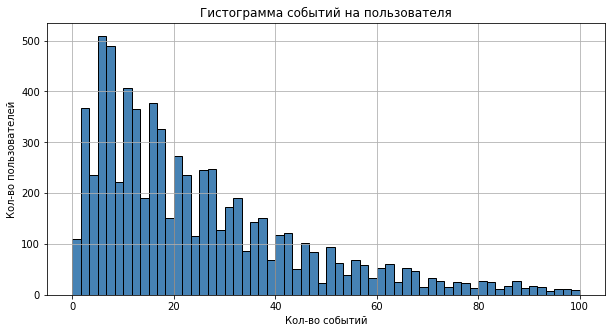

In [14]:
plt.figure(figsize=(10,5))
ev_per_us['count'].plot(kind='hist',range=(0,100), bins=60, grid = True, ec='black',color='steelblue');
plt.title('Гистограмма событий на пользователя')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Кол-во событий');

In [15]:
ev_per_us['count'].mean().round()#среднее число событий на пользователя

32.0

In [16]:
ev_per_us['count'].median().round()#медианное значение числа событий на пользователя

20.0

Согласно графику большинство пользователей совершали до 20 событий. Распределение экспоненциальное. Медиана в данном случае более предпочтительна, так как меньше подвержена влиянию выбросов.

In [17]:
data['date'].max()

datetime.date(2019, 8, 7)

In [18]:
data['date'].min()

datetime.date(2019, 7, 25)

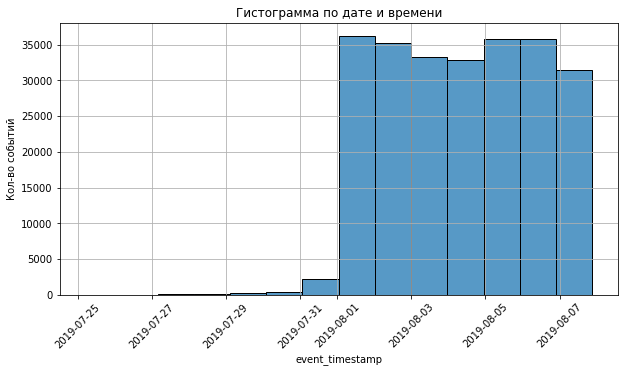

In [19]:
# гистрограмма по дате и времени
plt.figure(figsize=(10,5))
sns.histplot(data=data,x='event_timestamp', bins=14)
plt.title('Гистограмма по дате и времени')
plt.ylabel('Кол-во событий')
plt.grid()
plt.xticks(rotation=45 );

In [20]:
data_up = data[data['event_timestamp']>='2019-08-01']# обрежем данные 

In [21]:
#количество утеряннях пользователей 
user_qn_up = data_up['user_id'].nunique()
user_qn - user_qn_up

17

In [22]:
#количество утеряннях событий
event_qn -data_up['event_name'].count()

2826

In [23]:
(data.shape[0]-data_up.shape[0])*100/data.shape[0]# % утерянных данных

1.1595606307418973

In [24]:
data_up.pivot_table( index='exp_id', values='user_id', aggfunc='nunique')# пользователи по группам

,user_id
exp_id,
246,2484
247,2513
248,2537


**Вывод**

Данные представлены в период с 25 июля по 7 августа 2019 года. В среднем всего по 20 событий на пользователя. Но полные данные только с 1 августа. При удалении старых событий утеряно всего 1.16% данных. Также при этом сохранились пользователи из всех трёх экспериментальных групп.

## Воронка событий

In [25]:
# уникальные события и кол-во пользователей их совершивших
event_log = data_up.pivot_table(index='event_name',values = 'user_id', aggfunc=['count','nunique'])
event_log.columns = ['qn_event','qn_user']
event_log = event_log.sort_values(by='qn_event', ascending=False).reset_index()
event_log

,event_name,qn_event,qn_user
0,MainScreenAppear,117328,7419
1,OffersScreenAppear,46333,4593
2,CartScreenAppear,42303,3734
3,PaymentScreenSuccessful,33918,3539
4,Tutorial,1005,840


In [26]:
# доля пользователей, которые хоть раз совершали событие
event_log['rate'] = (event_log['qn_user']*100/(user_qn_up)).round(2)
event_log

,event_name,qn_event,qn_user,rate
0,MainScreenAppear,117328,7419,98.47
1,OffersScreenAppear,46333,4593,60.96
2,CartScreenAppear,42303,3734,49.56
3,PaymentScreenSuccessful,33918,3539,46.97
4,Tutorial,1005,840,11.15


Просмотр туториала является необязательной частью для того чтобы перейти на любой другой из имеющихся шагов.Соотвественно, данный шаг не вписывается в последовательную цепочку. 

In [27]:
# обрезка туториала
data_up = data_up[data['event_name']!= 'Tutorial']
event_log = event_log[event_log['event_name']!= 'Tutorial']

In [28]:
data_up.head()

,index,event_name,user_id,event_timestamp,exp_id,date
2827,2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
2831,2833,MainScreenAppear,4899590676214355127,2019-08-01 00:10:15,247,2019-08-01


In [1]:
#fig = px.funnel(event_log, y='event_name', x='qn_user',title='Воронка событий')
#fig.show()

In [30]:
# доля пользователей, проходящая на следующий шаг воронки
event_log['prev_step'] = event_log.shift(1,fill_value=0)['qn_user']
event_log['rate_next_step'] = round(event_log['qn_user']*100/event_log['prev_step'],2)
event_log

,event_name,qn_event,qn_user,rate,prev_step,rate_next_step
0,MainScreenAppear,117328,7419,98.47,0,inf
1,OffersScreenAppear,46333,4593,60.96,7419,61.91
2,CartScreenAppear,42303,3734,49.56,4593,81.30
3,PaymentScreenSuccessful,33918,3539,46.97,3734,94.78


In [31]:
# доля пользователей, которые дошли до оплаты
rate_user_payment = round(event_log.iloc[3]['qn_user']*100/event_log.iloc[0]['qn_user'],2)
rate_user_payment

47.7

**Вывод**

Больше всего пользователей теряется на втором шаге.Только 60% пользователей переходят к странице с предложением после главной страницы. И только 48% клиентов доходят до оплаты

## Анализ результатов A/A/B-эксперимента

In [32]:
# пользователи по группам
user_per_gr = data_up.pivot_table( index='exp_id', values='user_id', aggfunc='nunique').reset_index()
user_per_gr

,exp_id,user_id
0,246,2483
1,247,2512
2,248,2535


In [33]:
# пользователи по группами и по событиям
users_per_event = data_up.pivot_table( index='event_name', columns = 'exp_id', values='user_id', aggfunc='nunique')\
.sort_values(by=246, ascending=False).reset_index()
users_per_event.columns = ['event_name','246','247','248']
users_per_event

,event_name,246,247,248
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


In [2]:
#fig = px.funnel(users_per_event, y='event_name', x=['246','247','248'],title='Воронка событий в разрезе групп')
#fig.show()

In [35]:
# объеденная контрольная группа
users_per_event['246+247'] = users_per_event['246']+users_per_event['247']

In [36]:
# доля пользователей, совершивших событие
users_per_event['rate_A'] = round(users_per_event['246']*100/user_per_gr.iloc[0][1],2)
users_per_event['rate_A1'] = round(users_per_event['247']*100/user_per_gr.iloc[1][1],2)
users_per_event['rate_B'] = round(users_per_event['248']*100/user_per_gr.iloc[2][1],2)   
users_per_event

,event_name,246,247,248,246+247,rate_A,rate_A1,rate_B
0,MainScreenAppear,2450,2476,2493,4926,98.67,98.57,98.34
1,OffersScreenAppear,1542,1520,1531,3062,62.10,60.51,60.39
2,CartScreenAppear,1266,1238,1230,2504,50.99,49.28,48.52
3,PaymentScreenSuccessful,1200,1158,1181,2358,48.33,46.10,46.59


In [37]:
# функция для проверки гипотезы о равенстве долей
def check_rate(ex,ev,n,a):
    alpha = a # критический уровень статистической значимости

    successes = np.array(users_per_event[users_per_event['event_name']==ev][ex].values.tolist()[0])
    trials = np.array(n)

     # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
    difference = p1 - p2 
# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Проверка гипотезы о равенстве долей между группами {}. Событие: {}'.format(ex,ev) )
    
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 
    

**Гипотезы** 

Нулевая гипотеза: различий между долями групп нет. 

Альтернативная гипотеза: различия между долями групп есть. 


In [38]:
for ex in [['246','247'],['246','248'], ['247','248'],['246+247','248']]:# цикл по парам значений
    for ev in users_per_event['event_name']:# цикл по событиям
        # условие для определение n - размеры групп
        if ex == ['246','247']:
            n = user_per_gr.loc[:1]['user_id']
        elif ex == ['246','248']:
            n = user_per_gr.loc[user_per_gr['exp_id'].isin([246,248])]['user_id']
        elif ex == ['247','248']:
            n = user_per_gr.loc[1:2]['user_id']
        else:
            n = [user_per_gr.loc[:1]['user_id'].sum(axis=0),user_per_gr.loc[2]['user_id']]
        check_rate(ex,ev,n ,a=0.05)   # вызов функции

Проверка гипотезы о равенстве долей между группами ['246', '247']. Событие: MainScreenAppear
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка гипотезы о равенстве долей между группами ['246', '247']. Событие: OffersScreenAppear
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка гипотезы о равенстве долей между группами ['246', '247']. Событие: CartScreenAppear
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка гипотезы о равенстве долей между группами ['246', '247']. Событие: PaymentScreenSuccessful
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка гипотезы о равенстве долей между группами ['246', '248']. Событие: MainScreenAppear
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет осно

Так как было проведено несколько сравнений на одних и тех же данных, то это множественнй тест. Скорректируем уровень значимости методом Бонферрони с целью уменьшения вероятности ошибки первого рода. Всего произведено 16 сравнений. 

In [39]:
for ex in [['246','247'],['246','248'], ['247','248'],['246+247','248']]:
    for ev in users_per_event['event_name']:
        if ex == ['246','247']:
            n = user_per_gr.loc[:1]['user_id']
        elif ex == ['246','248']:
            n = user_per_gr.loc[user_per_gr['exp_id'].isin([246,248])]['user_id']
        elif ex == ['247','248']:
            n = user_per_gr.loc[1:2]['user_id']
        else:
            n = [user_per_gr.loc[:1]['user_id'].sum(axis=0),user_per_gr.loc[2]['user_id']]
        check_rate(ex,ev,n ,a=0.05/16)     

Проверка гипотезы о равенстве долей между группами ['246', '247']. Событие: MainScreenAppear
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка гипотезы о равенстве долей между группами ['246', '247']. Событие: OffersScreenAppear
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка гипотезы о равенстве долей между группами ['246', '247']. Событие: CartScreenAppear
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка гипотезы о равенстве долей между группами ['246', '247']. Событие: PaymentScreenSuccessful
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка гипотезы о равенстве долей между группами ['246', '248']. Событие: MainScreenAppear
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет осно

**Вывод**

Статистически значимых различий между группами А и А1 нет. Значит можно сказать, что разбиение на группы работает корректно.  Также нет статистически достоверных отличий между контрольными группами и экспериментальной, даже с учетом поправки Бонферрони. Соотвественно, изменение шрифта не приводит к желаемым результатам. 

**ИТОГИ**

Данные были представлены в период с 25 июля по 7 августа 2019 года. В среднем всего по 20 событий на пользователя.При анализе были учтены только логи с 1 августа. При удалении старых событий утеряно всего 1.16% данных. Также при этом сохранились пользователи из всех трёх экспериментальных групп.

Согласно воронке событий больше всего пользователей теряется на втором шаге: при переходе от главной экрана к экрану с предложением.(40%) 
И только 48% клиентов доходят до оплаты. 

Статистически значимых различий между двумя контрольными группами нет. Значит можно сказать, что разбиение на группы работает корректно.  Также нет статистически достоверных отличий между контрольными группами и экспериментальной.
Соотвественно, изменение шрифта не приводит к какому-либо влиянию на метрику. Нет оснований считать доли  экспериментальной группы (с новыми шрифтами) по каждому событию и доли контрольных групп - разными.